### Introducción a Clustering

El problema de clustering consiste en encontrar regularidades en los datos que nos permitan agruparlos por su similaridad. Es un problema similar al de clasificación, en donde entrenamos modelos para identificar las regularidades que caracterizan a distintas categorías dentro de los datos. Por ejemplo, si tenemos muchas imagenes de perros y gatos, podemos entrenar un modelo para separar el espacio de las features (en este caso valores de los pixeles de las imagenes) en regiones típicamente asociadas a imagenes de perros y otras asociadas a imagenes de gatos. Para encontrar esas regiones buscamos estructuras comunes dentro de un grupo de imagenes de perros y viceversa para las de los gatos. 



La diferencia fundamental entre los problemas de clasificación y clustering es que en los primeros conocemos las categorías que deseamos identificar, y contamos con las etiquetas para entrenar nuestros modelos en un esquema de aprendizaje supervisado, mientras que en los segundos no contamos con esa información. Puede ser que sepamos que nuestros datos pertenecen a diferentes categorías, pero no contemos con las etiquetas correspondientes, o puede ser que ni siquiera sepamos cuales son esas categorías pero querramos buscar si hay patrones que nos permitan seoarar a los datos en diferentes grupos. Un ejemplo sería mirar la historia de compras de muchos consumidores y tratar de agruparlos en clusters por similaridad.

<img src="img/clustering_vs_clasif.png" style="background-color:white" width=80%>

#### Métricas

Dado que el objetivo del clustering es encontrar grupos de datos similares entre sí, los resultados dependerán fuertemente de cómo midamos dicha similaridad. Es decir, de la métrica que usemos para medir distancias en el espacio de los datos (el espacio de las features). Recordemos que cada observación (cada fila en el dataframe) puede representarse como un vector en el espacio de features. Si alguna feature no fuera numérica podríamos convertirla a numérica creando variables dummy. 

Una familia de métricas muy usada son las de Minkowski, en donde dado un parámetro $p$, la distancia entre dos puntos es

\begin{equation}
d_p(\vec{x_i},\vec{x_j})=\left( \sum_{k=1}^d \vert x_{ik}-x_{jk}\vert^{p}\right)^{\frac{1}{p}}
\end{equation}

en donde $\vec{x_i}$ es el dato i-ésimo representado como un vector de $d$ dimensiones (features). Cuando el parámetro es $p=2$ tenemos la distancia euclídea, que es la que se usa por defecto en la mayoría de los casos. $p=1$ define la distancia de Manhattan o city block.

<img src="img/minkowski.png">

Cuando $p=1$ y los vectores $\vec{x}$ son booleanos, por ejemplo si cada valor representa la presencia o ausencia de un atributo, se habla de la distancia de "Hamming", en donde contamos el número (o fracción) de coordenadas en las que difieren los dos vectores.

#### Normalización

Dado que los métodos de clustering dependen de una medida de distancia en el espacio de las features, es muy importante que las mismas se encuentren en la misma escala. Supongamos que tenemos un dataset de animales con las siguientes observaciones:


In [1]:
import pandas as pd
import numpy as np
Nombre=['Vaca','Toro','Ciervo','Jabali','Leon','Cocodrilo','Tigre']
Pesos=[720,1100,200,175,190,500,300]
Carnivoro=[0,0,0,0,1,1,1];

Animales=pd.DataFrame({'Animal':Nombre,'Peso':Pesos,'Carnivoro':Carnivoro})
display(Animales)


,Animal,Peso,Carnivoro
0,Vaca,720,0
1,Toro,1100,0
2,Ciervo,200,0
3,Jabali,175,0
4,Leon,190,1
5,Cocodrilo,500,1
6,Tigre,300,1


Si calculamos las distancias euclídeas entre los datos en el espacio de las features (Peso - Carnívoro):

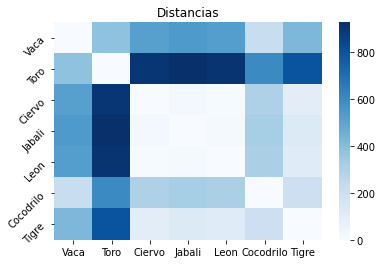

In [2]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(squareform(pdist(Animales[['Peso','Carnivoro']])),cmap='Blues')
plt.xticks(np.arange(1,len(Nombre)+1)-0.5,Nombre);
plt.yticks(np.arange(1,len(Nombre)+1)-0.5,Nombre,rotation=45);
plt.title('Distancias');

Vemos cómo ciervo, jabalí y león están muy cerca entre sí y la vaca está más cerca del cocodrilo que del toro. Esto es porque el peso está determinando la distancia entre todos los animales. Para que la alimentación tenga un peso comparable en el cálculo de las distancias debemos llevar ambas features a la misma escala. Veamos cómo queda la matriz al estandarizar las features, es decir, restando la media y dividiendo por la desviación estandar.

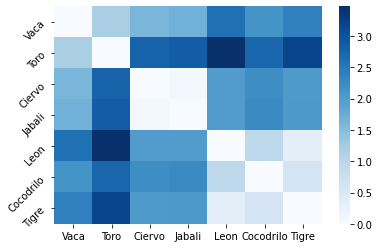

In [3]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_features=scaler.fit_transform(Animales[['Peso','Carnivoro']])
sns.heatmap(squareform(pdist(scaled_features)),cmap='Blues')
plt.xticks(np.arange(1,len(Nombre)+1)-0.5,Nombre);
plt.yticks(np.arange(1,len(Nombre)+1)-0.5,Nombre,rotation=45);

Ahora vemos una estructura más razonable, en donde Tigre -Cocodrilo - León están muy cerca entre sí, lo mismo que ciervo -jabalí y vaca - toro.

## K-means

K-means es uno de los algoritmos más famosos para la identificación de clusters, por su simplicidad y eficiencia. En este algoritmo cada punto en el espacio de las features será asignado a uno de k clusters, en donde k es un hiperparámetro del modelo que se fija a priori. El criterio para agrupar los datos es por su cercanía a ciertos puntos en el espacio llamados centroides. 

En su versión más simple, el algoritmo funciona de la siguiente manera:

1. Se eligen k puntos en el espacio al azar, que serán los centroides. En algunas implementaciones estos puntos son k datos sampleados al azar.

2. Se etiqueta cada punto con el número de centroide más cercano, definiendo así k-clusters.

3. Se redefinen los centroides como los centros geométricos de los puntos dentro de cada cluster. Dicho de otra forma, la posición nueva de cada centroide es el promedio de las posiciones de los puntos asignados al cluster.

4. Se repiten los pasos 2-3 hasta que el algoritmo converge, es decir, hasta que la composición de los clusters no cambia.

De esta manera, el algoritmo busca minimizar una función de costo (J) que es la suma de las distancias al cuadrado de los puntos al centroide de su cluster, o, lo que es lo mismo, la varianza dentro de cada cluster:

\begin{equation}
J=\sum_{j=1}^k \sum_{\vec{x} \in S_j} \vert\vert \vec{x} - \vec{c}_j \vert\vert^2
\end{equation}

en donde $\vec{c}_j$ es el centroide del cluster $S_j$.


La siguiente figura muestra dos iteraciones del algoritmo en un ejemplo con dos features y k=3:

<img src="img/kmeans.png" style="background-color:white" width=70%>

#### Ventajas de K-means

* <b>Simplicidad</b>: Es fácil de entender e implementar
* <b>Eficiencia</b>: La complejidad (tiempo de cómputo) es de orden O(tkn), en donde n es el número de puntos, k el número de clusters y t el número de iteraciones. Como k y t son prácticamente independientes de n, el algoritmos es lineal en el número de datos.

#### Algunos problemas de K-means

* El método iterativo propuesto es eficiente pero no garantiza la convergencia al mínimo global de J. Por este motivo, dependiendo de las posiciones con que se inicializan los centroides el algoritmo puede converger a distintos mínimos locales. Una manera de mejorar este problema es hacer varias realizaciones del ajuste y elegir el resultado con menor costo J. 

* K es un hiperparámetro, es decir que no se aprende de los datos. Veremos luego algunos criterios para elegirlo.

* El algoritmo se basa en la hipótesis de que los clusters tienen una geometría esférica, por ese motivo busca minimizar la distancia euclídea (al cuadrdado). Si los clusters tuvieran otra geometría es muy probable que k-means no los encuentre.

* K-means es sensible a outliers. Como todos los puntos son sí o sí asignados a algún cluster, la presencia de outliers en los datos sesgaría la estimación de los centroides y podría afectar el resultado final del clustering. Una posible solución es volver a correr el algoritmo elimintando puntos que hayan quedado muy lejos de su centroide (muy lejos comparado con el resto de los puntos en el cluster). Otra aproximación es implementar el algoritmo sobre una muestra aleatoria de los datos: dado que los outliers son poco frecuentes, la probabilidad de incluirlos en la muestra es baja.

#### Ejemplo de K-means

Trabajaremos con un dataset sobre consumidores de un shopping. Pueden consultar el dataset y un análisis descriptivo seguido de clustering [acá](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python). 

In [4]:
data=pd.read_csv('../Data/mall_customers.csv')
display(data.head(5))

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Hagamos un pairplot para ver un poco la estructura de nuestros datos. Antes renombremos las columnas 4 y 5 por comodidad.

In [5]:
data.rename({'Annual Income (k$)':'Income','Spending Score (1-100)':'Spending Score'},axis=1,inplace=True)
display(data.head(5))

,CustomerID,Gender,Age,Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


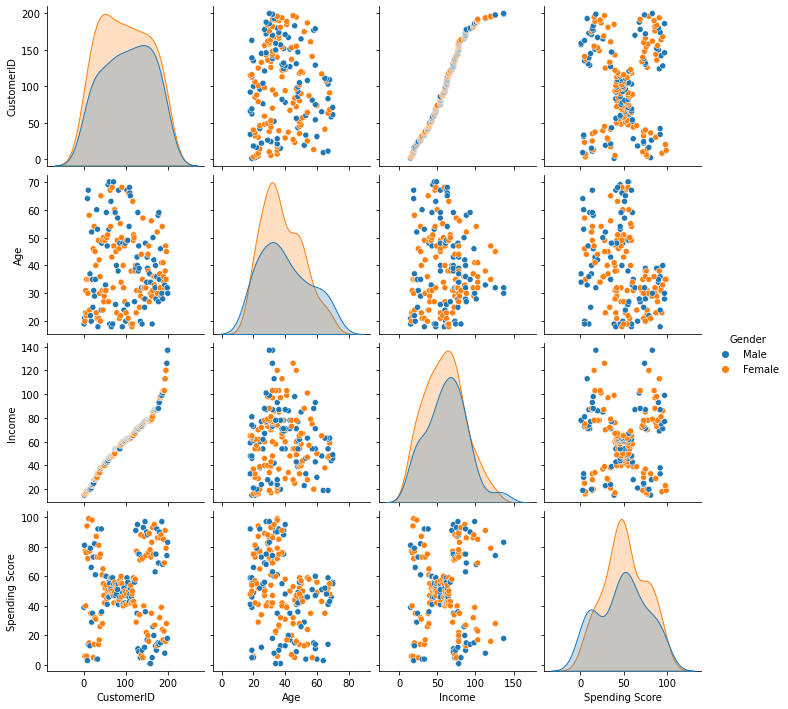

In [7]:
sns.pairplot(data,hue='Gender');

Algunas cosas que se ven a simple vista:

* No hay diferencias por género
* Los números de Id están ordenados por ingreso anual
* Hay una estructura peculiar en el gráfico de Ingreso anual vs Spending Score, en la que se observan 5 clusters 

Tratemos de identificar los clusters en el gráfico de Ingreso anual vs Spending Score usando k-means. Si bien estas variables están en la misma escala, estandaricémoslas para adquirir el hábito.

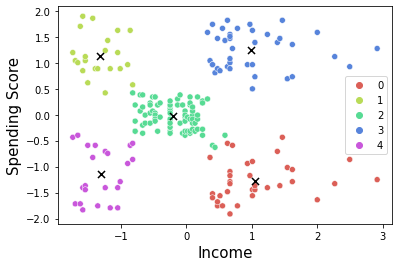

In [8]:
from sklearn.cluster import KMeans

X=data[['Income','Spending Score']]

scaler=StandardScaler()

X_scaled=scaler.fit_transform(X);

kmeans=KMeans(n_clusters=5,n_init=10,random_state=0) # Numero de repeticiones=10
kmeans.fit(X_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=X_scaled[:,0],y=X_scaled[:,1],hue=labels,legend='full',palette=sns.color_palette("hls", 5));
plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');


### Cómo elegir k y evaluar el clustering

En algunos problemas uno conoce a priori el número de clusters que busca. Por ejemplo si queremos identificar tumores malignos/benignos dadas sus características morfológicas. En otros casos el k lo determinamos para satisfacer algún criterio externo a los datos. Por ejemplo necesitamos generar k grupos de sujetos lo más homogéneos posibles en cada grupo para participar de un experimento. 

Pero una condición más general se da cuando uno debe determinar el valor de k a partir de la propia estructura de los datos. En el ejemplo de los consumidores pudimos ver a ojo que el número de clusters que buscábamos era 5. Esto fue posible al visualizar los datos en dos dimensiones, cosa que evidentemente no siempre podremos hacer. 

Veremos a continuación algunas estrategias para elegir el valor de k y evaluar la "calidad" del clustering.

En primer lugar podríamos usar como métrica la suma de las distancias cuadráticas de los puntos a sus centroides. Esto constituiría una medida de error, ya que uno desearía que los puntos estén cerca del centroide de su cluster.

<b>¿Qué esperan que pase con esta métrica a medida que aumentamos k?</b>


El atributo 'inertia_' del modelo kmeans tiene precisamente dicha suma de distancias cuadráticas a los centroides. Veamos cómo varía con k.


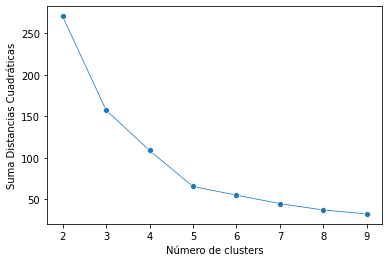

In [9]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');    

A medida que aumentamos el número de clusters, la suma de distancias cuadráticas se achica. Evidentemente, si k fuera igual a n, habría un centroide para cada punto y las distancias serían todas iguales a cero.

Un criterio para elegir el k mirando este gráfico es la <b>["regla del codo"](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)</b> , en donde se elige el k a partir del cual la curva se aplana. Es decir, a partir del cual la incorporación de un nuevo cluster no explica mucha más varianza de los datos. En este caso se ve que k=5 es una buena opción.

#### Silhouette score

El coeficiente silhouette mide cuán cercano es un punto al resto de los que están en su mismo cluster, en relación a cuán cercano es a los puntos del cluster más próximo. Es decir que para cada punto $i$, se tiene un coeficiente $s_i$

$$
s_i=\frac{b(i)-a(i)}{max\{a(i),b(i)\}}
$$

en donde $a(i)$ es la distancia promedio a todos los otros puntos dentro del mismo cluster y $b(i)$ es la distancia promedio a todos los puntos del cluster vecino más cercano. De esta manera

$$
-1\le s_i \le 1
$$

Si $s$ es cercano a 1, significa que el punto $i$ está correctamente etiquetado; $s$ cercano a cero indica que estaría igual de bien (o mal) etiquetarlo con el cluster vecino más cercano; y $s$ cercano a -1 significa que el punto $i$ está mal etiquetado y pertenece al cluster vecino.

Para obtener un score del clustering podemos promediar los coeficientes:

$$
S(C)=\frac{1}{k}\sum_{j=1}^k \bar{s}_j
$$

en donde $\bar{s}_j$ es el coeficiente promedio de todos los puntos dentro del cluster j-ésimo.

Grafiquemos el score en función de k en nuestro dataset:

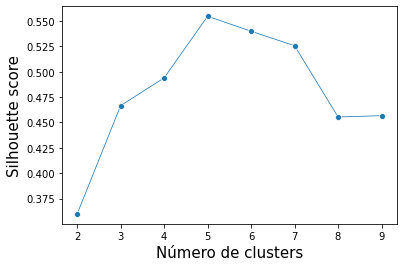

In [10]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    score=silhouette_score(X_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

El gráfico de arriba nos muestra el silhouette score promedio para cada valor de k, y nuevamente vemos que el valor óptimo es $k=5$. Si queremos mirar más en detalle, podemos graficar las distribuciones de los coeficientes $s_i$ para cada partición de los datos:

For n_clusters = 2 The average silhouette_score is : 0.28793808282017214
For n_clusters = 3 The average silhouette_score is : 0.46658474419000145
For n_clusters = 4 The average silhouette_score is : 0.4939069237513199
For n_clusters = 5 The average silhouette_score is : 0.5546571631111091
For n_clusters = 6 The average silhouette_score is : 0.5380630705007141
For n_clusters = 7 The average silhouette_score is : 0.5317107324040978
For n_clusters = 8 The average silhouette_score is : 0.45460807466743275
For n_clusters = 9 The average silhouette_score is : 0.455477460588866


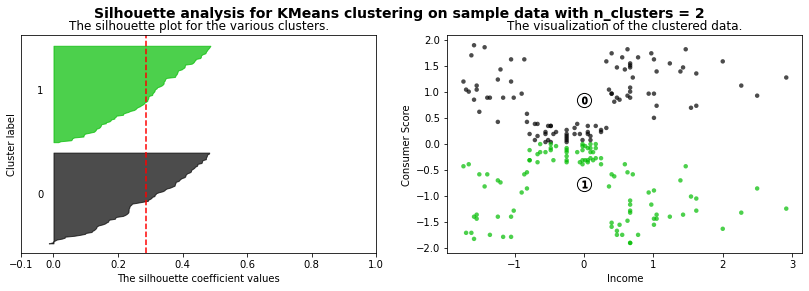

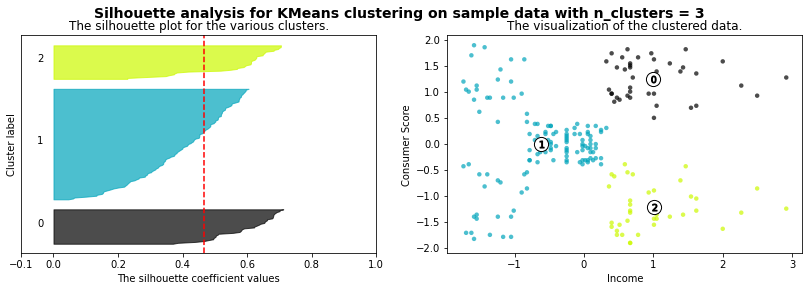

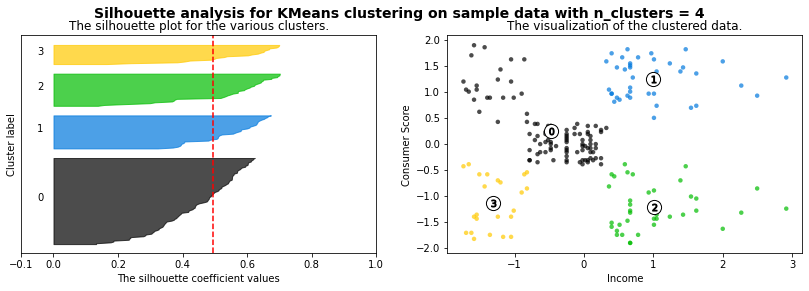

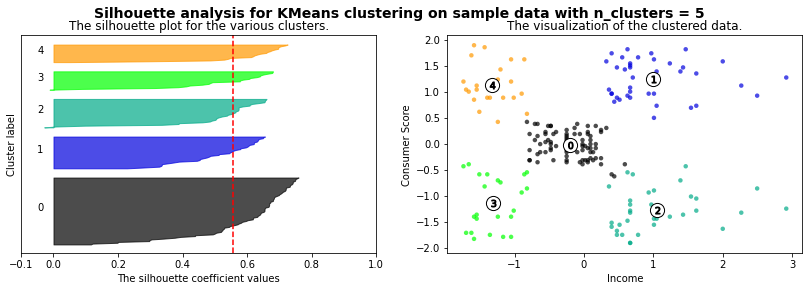

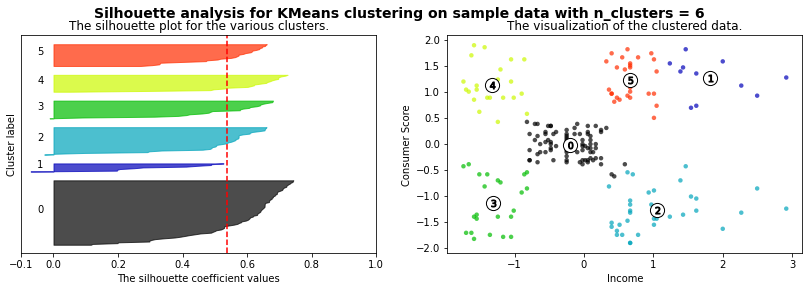

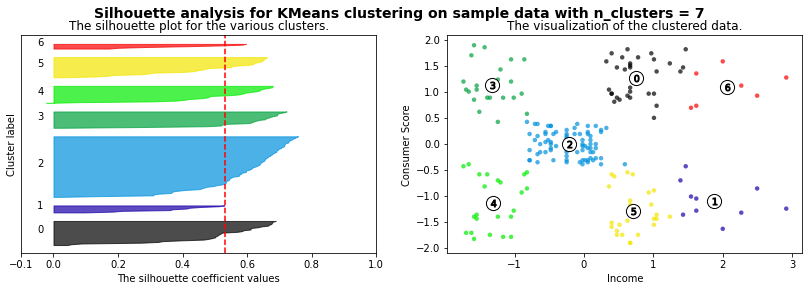

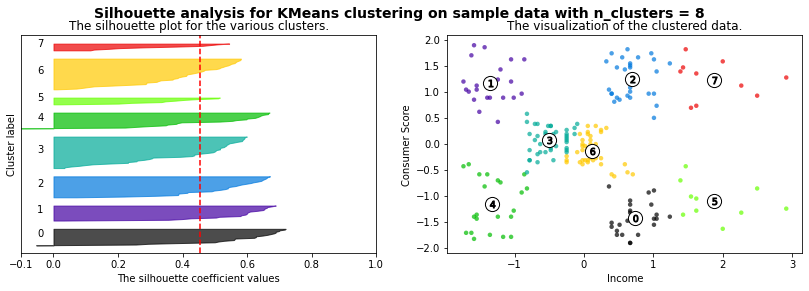

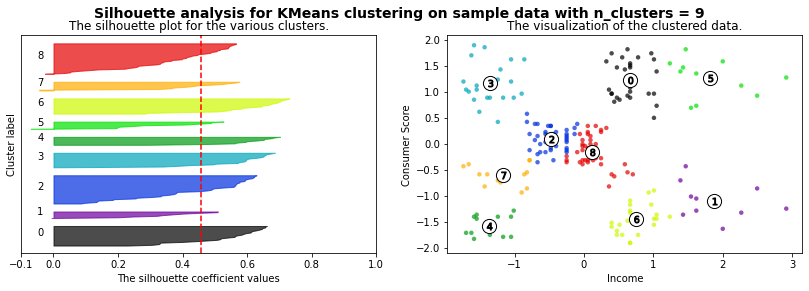

In [11]:
import matplotlib.cm as cm

for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Income")
    ax2.set_ylabel("Consumer Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

En los gráficos de más arriba, la linea roja punteada es el score promedio (lo mismo que graficamos antes en función de k). Luego para cada cluster se ve los valores de $s_i$, de modo que podemos ver cuáles clusters son los mejor definidos. En el último gráfico (n_clusters=9) se ve que los clusters 3,4 y 6 son los mejor definidos (todos los valores de $s$ están por encima de la media). Pueden consultar el código para hacer los gráficos y una discusión ampliada sobre su interpretación [acá](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

#### Calinski-Harabasz score

Otra métrica para evaluar la calidad del clustering es el [score Calinski-Harabasz](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index) que mide la relación entre la dispersión inter-clusters y la dispersión intra-clusters. Matemáticamente se define así:

$$
s(k)=\frac{Tr(B_k)}{Tr(W_k)}\frac{N-k}{k-1}
$$

en donde $Tr(B_k)$ y $Tr(W_k)$ son las trazas de las matrices de dispersión entre clusters $B_k$ e intra clusters $Tr(W_k)$.

<b>Dicho en criollo</b>, una estructura de clusters bien definidos daría una alta dispersión entre clusters diferentes y baja dispersión dentro de cada cluster. El factor $\frac{Tr(B_k)}{Tr(W_k)}$ tiende a aumentar con el número de clusters, puesto que al aumentar k estamos generando clusters más chicos y por ende menos dispersos. El segundo factor $\frac{N-k}{k-1}$ busca controlar este efecto: tiende a cero cuando k tiende a N. Dependiendo de la estructura de los datos puede ser que aparezca un pico bien definido que nos permita elegir el k o puede ser que para valores razonable de k el score sea creciente pero podamos usar un criterio como la "regla del codo".


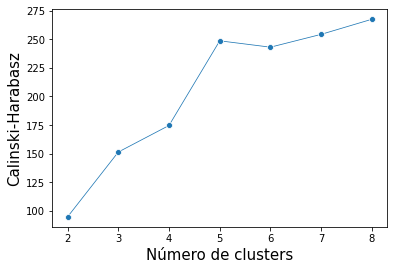

In [12]:
from sklearn.metrics import calinski_harabasz_score

k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    score=calinski_harabasz_score(X_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);


## K-modes, cuando las variables son categóricas

K-means tiene sentido cuando las variables son continuas. Si tuvieramos alguna variable categórica podríamos incluirla en el análisis creando las variables dummy correspondientes (y estandarizándolas debidamente!). Pero si todos los datos fueran categóricos, como por ejemplo el caso de moléculas de adn o cadenas de aminoácidos formando proteínas, tendría sentido modificar el algoritmo.

K-modes es una modificación muy intuitiva, en donde los centroides están definidos por las modas (valor más frecuente) de cada feature, medidas sobre los puntos que forman cada cluster. La distancia entre dos puntos, en lugar de ser la euclídea, se define como el número de features en los cuales no coinciden los valores.

Pueden encontrar un ejemplo aquí:

https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering



